<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE60499](https://ndcbe.github.io/CBE60499);
content is available [on Github](git@github.com:ndcbe/CBE60499.git).*


<!--NAVIGATION-->
< [4.0 Constrained Nonlinear Optimization: Theory and Applications](https://ndcbe.github.io/CBE60499/04.00-Constrained.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [4.2 Local Optimality Conditions](https://ndcbe.github.io/CBE60499/04.02-Local-Optimality.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/04.01-Convexity.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/04.01-Convexity.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 4.1 Convexity Revisited

In [1]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()
    helper.install_glpk()
    helper.download_figures(['pack1.png','pack2.png','pack3.png'])

In [2]:
import pandas as pd
import pyomo.environ as pyo

## 4.1.1 Background

**Reference**: Beginning of Chapter 4 in Biegler (2010)

### 4.1.1.1 Canonical Nonlinear Program

![picture](./figures/general_nlp.png)

### 4.1.1.2 Types of Constrained Optimal Solutions

![picture](./figures/def_4_1_a.png)

![picture](./figures/def_4_1_b.png)

### 4.1.1.3 Key Questions

![picture](./figures/4_1_questions.png)

## 4.1.2 Convexity for Constrained Optimization

**Reference**: Section 4.1 in Biegler (2010)

![picture](./figures/thm_4_2.png)

![picture](./figures/thm_4_3.png)

## 4.1.3 Circle Packing Example

**Reference**: Section 4.1 in Biegler (2010)

**Motivating Question**: Is this problem convex?

What is the smallest rectangle you can use to enclose three given circles? Reference: Example 4.4 in Biegler (2010).

![picture](./figures/pack1.png)

### 4.1.3.1 Optimization Model and Pyomo Implementation

The following optimization model is given in Biegler (2010):

![picture](./figures/pack2.png)
![picture](./figures/pack3.png)

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def create_circle_model(circle_radii):
    ''' Create circle optimization model in Pyomo
    
    Arguments:
        circle_radii: dictionary with keys=circle name and value=radius (float)
        
    Returns:
        model: Pyomo model
    '''

    # Number of circles to consider
    n = len(circle_radii)

    # Create a concrete Pyomo model.
    model = pyo.ConcreteModel()

    # Initialize index for circles
    model.CIRCLES = pyo.Set(initialize = circle_radii.keys())
    
    # Create parameter
    model.R = pyo.Param(model.CIRCLES, domain=pyo.PositiveReals, initialize=circle_radii)

    # Create variables for box
    model.a = pyo.Var(domain=pyo.PositiveReals)
    model.b = pyo.Var(domain=pyo.PositiveReals)

    # Set objective
    model.obj = pyo.Objective(expr=2*(model.a + model.b), sense = pyo.minimize)

    # Create variables for circle centers
    model.x = pyo.Var(model.CIRCLES, domain=pyo.PositiveReals)
    model.y = pyo.Var(model.CIRCLES, domain=pyo.PositiveReals)

    # "In the box" constraints
    def left_x(m,c):
        return m.x[c] >= model.R[c]
    model.left_x_con = pyo.Constraint(model.CIRCLES, rule=left_x)

    def left_y(m,c):
        return m.y[c] >= model.R[c]
    model.left_y_con = pyo.Constraint(model.CIRCLES, rule=left_y)

    def right_x(m,c):
        return m.x[c] <= m.b - model.R[c]
    model.right_x_con = pyo.Constraint(model.CIRCLES, rule=right_x)

    def right_y(m,c):
        return m.y[c] <= m.a - model.R[c]
    model.right_y_con = pyo.Constraint(model.CIRCLES, rule=right_y)

    # No overlap constraints
    def no_overlap(m,c1,c2):
        if c1 < c2:
            return (m.x[c1] - m.x[c2])**2 + (m.y[c1] - m.y[c2])**2 >= (model.R[c1] + model.R[c2])**2
        else:
            return pyo.Constraint.Skip
    model.no_overlap_con = pyo.Constraint(model.CIRCLES, model.CIRCLES, rule=no_overlap)
    
    return model

def initialize_circle_model(model, a_init=25, b_init=25):
    ''' Initialize the x and y coordinates using uniform distribution
    
    Arguments:
        a_init: initial value for a (default=25)
        b_init: initial value for b (default=25)
        
    Returns:
        Nothing. But per Pyomo scoping rules, the input argument `model`
        can be modified in this function.
    
    '''
    # Initialize 
    model.a = 25
    model.b = 25

    for i in model.CIRCLES:
        # Adding circle radii ensures the remains in the >0, >0 quadrant
        model.x[i] = random.uniform(0,10) + model.R[i]
        model.y[i] = random.uniform(0,10) + model.R[i]



Next, we will create a dictionary containing the circle names and radii values.

In [4]:
# Create dictionary with circle data
circle_data = {'A':10.0, 'B':5.0, 'C':3.0}
circle_data

{'A': 10.0, 'B': 5.0, 'C': 3.0}

In [5]:
# Access the keys
circle_data.keys()

dict_keys(['A', 'B', 'C'])

Now let's create the model.

In [6]:
# Create model
model = create_circle_model(circle_data)

And let's initialize the model.

In [7]:
# Initialize model
initialize_circle_model(model)
model.pprint()

2 Set Declarations
    CIRCLES : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'C'}
    no_overlap_con_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain          : Size : Members
        None :     2 : CIRCLES*CIRCLES :    9 : {('A', 'A'), ('A', 'B'), ('A', 'C'), ('B', 'A'), ('B', 'B'), ('B', 'C'), ('C', 'A'), ('C', 'B'), ('C', 'C')}

1 Param Declarations
    R : Size=3, Index=CIRCLES, Domain=PositiveReals, Default=None, Mutable=False
        Key : Value
          A :  10.0
          B :   5.0
          C :   3.0

4 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    25 :  None : False : False : PositiveReals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    25 :  None : False : False : PositiveReals
    x : Size=3, Index=CIRCLES
     

### 4.1.3.2 Visualize Initial Point

Next, we'll define a function to plot the solution (or initial point)

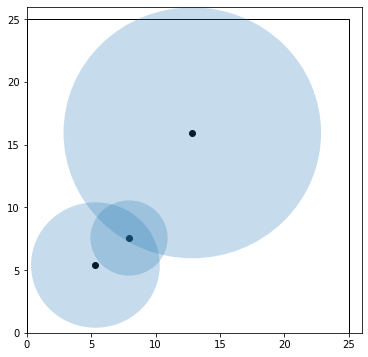

In [8]:
# Plot initial point

def plot_circles(m):
    ''' Plot circles using data in Pyomo model
    
    Arguments:
        m: Pyomo concrete model
    
    Returns:
        Nothing (but makes a figure)
    
    '''
    
    # Create figure
    fig, ax = plt.subplots(1,figsize=(6,6))
    
    # Adjust axes
    l = max(m.a.value,m.b.value) + 1
    ax.set_xlim(0,l)
    ax.set_ylim(0,l)
    
    # Draw box
    art = mpatches.Rectangle((0,0), width=m.b.value, height=m.a.value,fill=False)
    ax.add_patch(art)

    # Draw circles and mark center
    for i in m.CIRCLES:
        art2 = mpatches.Circle( (m.x[i].value,m.y[i].value), radius=m.R[i],fill=True,alpha=0.25)
        ax.add_patch(art2)
        
        plt.scatter(m.x[i].value,m.y[i].value,color='black')
    
    # Show plot
    plt.show()
    
plot_circles(model)

### 4.1.3.3 Solve and Inspect the Solution

In [9]:
# Specify the solver
solver = pyo.SolverFactory('ipopt')

# Solve the model
results = solver.solve(model, tee = True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       30
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:        8
                     variables with only lower bounds:        8
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of ineq

Next, we can inspect the solution. Because Pyomo is a Python extension, we can use Pyoth (for loops, etc.) to programmatically inspect the solution.

Name	Value
a 	 29.142135416184022
b 	 19.999999803189596
x[A] 	 9.99999990193744
x[B] 	 4.999999953543133
x[C] 	 15.734851787229463
y[A] 	 19.142135514931184
y[B] 	 4.999999951252124
y[C] 	 5.517617033892999


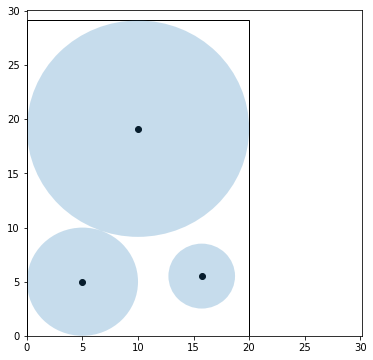

In [10]:
# Print variable values
print("Name\tValue")
for c in model.component_data_objects(pyo.Var):
    print(c.name,"\t", pyo.value(c))

# Plot solution
plot_circles(model)

In [11]:
# Print constraints
for c in model.component_data_objects(pyo.Constraint):
    print(c.name,"\t", pyo.value(c.lower),"\t", pyo.value(c.body),"\t", pyo.value(c.upper))

left_x_con[A] 	 10.0 	 9.99999990193744 	 None
left_x_con[B] 	 5.0 	 4.999999953543133 	 None
left_x_con[C] 	 3.0 	 15.734851787229463 	 None
left_y_con[A] 	 10.0 	 19.142135514931184 	 None
left_y_con[B] 	 5.0 	 4.999999951252124 	 None
left_y_con[C] 	 3.0 	 5.517617033892999 	 None
right_x_con[A] 	 None 	 9.874784367980283e-08 	 0.0
right_x_con[B] 	 None 	 -9.999999849646462 	 0.0
right_x_con[C] 	 None 	 -1.2651480159601327 	 0.0
right_y_con[A] 	 None 	 9.87471615587765e-08 	 0.0
right_y_con[B] 	 None 	 -19.142135464931897 	 0.0
right_y_con[C] 	 None 	 -20.624518382291022 	 0.0
no_overlap_con[A,B] 	 225.0 	 224.99999778541908 	 None
no_overlap_con[A,C] 	 169.0 	 218.51602998638847 	 None
no_overlap_con[B,C] 	 64.0 	 115.5049713354404 	 None


### 4.1.3.4 Reinitialize and Resolve

Reinitialize the model, plot the initial point, resolve, and plot the solution. Is there more than one solution?

In [12]:
# Initialize and print the model
initialize_circle_model(model)

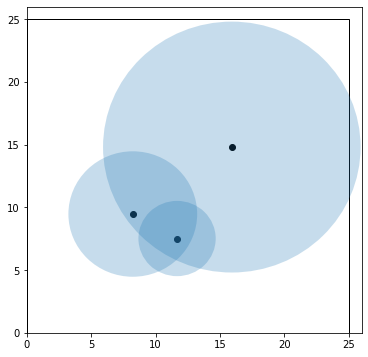

In [13]:
# Plot initial point
plot_circles(model)

In [14]:
# Solve the model
results = solver.solve(model, tee = True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       30
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:        8
                     variables with only lower bounds:        8
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of ineq

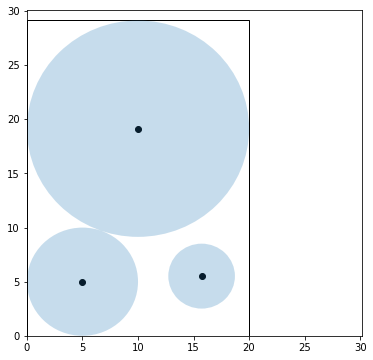

In [15]:
# Plot solution
plot_circles(model)

## 4.1.4 Take Away Messages
* Nonlinear programs may be nonconvex. For nonconvex problems, there often exists many local optima that are not also global optima.
* Initialization is really important in optimization problems with nonlinear objectives or constraints!

<!--NAVIGATION-->
< [4.0 Constrained Nonlinear Optimization: Theory and Applications](https://ndcbe.github.io/CBE60499/04.00-Constrained.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [4.2 Local Optimality Conditions](https://ndcbe.github.io/CBE60499/04.02-Local-Optimality.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/04.01-Convexity.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/04.01-Convexity.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>